# Test Driven Model Development Using a Nice Sphere
Tim Tyree<br>
6.26.2020

In [219]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
sys.path.append("../lib") 
from lib import *
sys.path.append("lib") 
from lib import *

# from operari import *
# from ProgressBar import *
# from mesh_ops import *

# the visualization tools involved here for triangular meshes is
import trimesh
import pyglet
from numba import njit, cuda
# from numba.typed import List
# import numba
import trimesh

#try using a scipy sparse matrix to speed up spring force evaluations
#TODO: consider speeding up bigger meshes with pycuda's sparce matrices
from scipy.sparse import csr_matrix
import scipy.sparse as sparse

#formating
from matplotlib import rc
rc('text', usetex=True)

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import a mesh of the unit 2-sphere

In [215]:
os.chdir(f'{nb_dir}/Data/spherical_meshes')
mesh = trimesh.load('spherical_mesh_64.stl')
#subtract the center of mass
mesh.vertices -= mesh.center_mass
#normalize the mean radius to 1
mesh.vertices /= np.cbrt(mesh.volume*3/(4*np.pi))

#normalize the mean radius to R
# R = 1. #unit length
# mesh.vertices *= R/np.mean(np.linalg.norm(mesh.vertices,axis=1))

face_normals all zero, ignoring!


In [216]:
assert(mesh.is_watertight)
assert(mesh.is_winding_consistent)

In [217]:
# unit length check
print(np.mean(np.linalg.norm(mesh.vertices,axis=1)))
print(np.cbrt(mesh.volume*3/(4*np.pi)))

1.0083893459591489
0.9999999999999999


## [deprecated, just use real space, dude.]

In [5]:
#doesn't work. don't know why
# def mat_to_str(A):
#     string = f'''
#     {A[[0,0]]} & {A[[0,1]]} & {A[[0,2]]} & {A[[0,3]]} \\ 
#     {A[[1,0]]} & {A[[1,1]]} & {A[[1,2]]} & {A[[1,3]]} \\ 
#     {A[[2,0]]} & {A[[2,1]]} & {A[[2,2]]} & {A[[2,3]]} \\ 
#     {A[[3,0]]} & {A[[3,1]]} & {A[[3,2]]} & {A[[3,3]]} \\ 
#     '''
#     latex_string = r'$\left( \begin{array}{ll} ' + string + r'\end{{array}} \right)$'
#     return latex_string
# # text(my_matrix, (1,1))

### [deprecated, use real space] cast all vertices and shapes to quaternions in numpy. record as the undeformed surface
- TODO: dilate the sphere by a known amount
- TODO: compute the deformation gradient
- TODO: compute the 1st piola-kirchoff tensor for some constitutive relation
- TODO: taking thickness to be $\delta\ll1$, compute the effective surface tension, $\gamma$

In [6]:
from colorsys import hls_to_rgb

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c

In [7]:
#define the constant pauli matrices as a basis for real space
sigx = 1.j*np.array([[0.,1.],[1.,0.]],dtype=complex)
sigy = 1.j*np.array([[0.,-1.j],[1.j,0.]],dtype=complex)
sigz = 1.j*np.array([[1.,0.],[0.,-1.]],dtype=complex)
one  = np.array([[1.,0.],[0.,1.]],dtype=complex)
zero = np.array([[0.,0.],[0.,0.]],dtype=complex)

#print the imaginary spatial basis, and test that identity and zero multiply correctly.
print(r'$\sigma_x is $')
print(sigx)
print(r'$\sigma_y is $')
print(sigy)
print(r'$\sigma_z is $')
print(sigz)
# print(one)
# print(zero)
# print((one.dot(sigx)))
assert((one.dot(sigx)==sigx).all())
assert((zero.dot(sigx)==zero).all())

# @njit
def vec_to_quaternion(v):
    #define the constant pauli matrices as a basis for real space
    #     sigx = np.array([[0.,1.],[1.,0.]],dtype=complex)
    #     sigy = np.array([[1.j,0.],[0.,-1.j]],dtype=complex)
    #     sigz = np.array([[1.,0.],[0.,-1.]],dtype=complex)
    return v[0]*sigx + v[1]*sigy + v[2]*sigz

$\sigma_x is $
[[0.+0.j 0.+1.j]
 [0.+1.j 0.+0.j]]
$\sigma_y is $
[[ 0.+0.j  1.-0.j]
 [-1.+0.j  0.+0.j]]
$\sigma_z is $
[[ 0.+1.j  0.+0.j]
 [ 0.+0.j -0.-1.j]]


In [8]:
#test the inverse of the basis elements are minus the basis elements
assert((np.linalg.inv(sigx)==-sigx).all())
assert((np.linalg.inv(sigy)==-sigy).all())
assert((np.linalg.inv(sigz)==-sigz).all())
#test the basis elements are anticommuting
assert((sigx*sigy-sigy*sigx==zero).all())
assert((sigx*sigz-sigz*sigx==zero).all())
assert((sigz*sigy-sigy*sigz==zero).all())


In [9]:
trim = mesh.triangles[0]
tris = mesh.triangles[100]

dm1 = trim[1]-trim[0]
dm2 = trim[2]-trim[0]
Am =  np.cross(dm1,dm2)/2

ds1 = tris[1]-tris[0]
ds2 = tris[2]-tris[0]
As =  np.cross(ds1,ds2)/2


qm1 = dm1[0]*sigx + dm1[1]*sigy + dm1[2]*sigz
qm2 = dm2[0]*sigx + dm2[1]*sigy + dm2[2]*sigz
qs1 = ds1[0]*sigx + ds1[1]*sigy + ds1[2]*sigz
qs2 = ds2[0]*sigx + ds2[1]*sigy + ds2[2]*sigz

qAm =  Am[0]*sigx + Am[1]*sigy + Am[2]*sigz
qAs =  As[0]*sigx + As[1]*sigy + As[2]*sigz

# solve for the deformation gradient between either pair of edges.
F1 = qs1.dot(np.linalg.inv(qm1))
F2 = qs2.dot(np.linalg.inv(qm2))
# FA = qAs.dot(np.linalg.inv(qAm))

In [10]:
#singular value decomposition on the block diagonal deformations
U1, S1, V1 = np.linalg.svd(F1)
V1 = V1.T.conjugate()

U2, S2, V2 = np.linalg.svd(F2)
V2 = V2.T.conjugate()

In [11]:
#verify svd is returning hermitian factors
assert((np.around(U1.dot(U1.T.conjugate()),3)==one).all())
assert((np.around(V1.dot(V1.T.conjugate()),3)==one).all())

In [12]:
Dm = np.array(((qm1,zero),(zero,qm2))).reshape((4,4))
Ds = np.array(((qs1,zero),(zero,qs2))).reshape((4,4))

In [13]:
#TODO: test if rotating by F maps dm to ds
F1.dot(qm1).dot(F1.conjugate().T)

array([[ 0.00000000e+00-0.0020773j , -2.64751533e-01-0.23108376j],
       [ 2.64751533e-01-0.23108376j, -6.93889390e-18+0.0020773j ]])

In [14]:
np.linalg.svd(Dm)

(array([[-8.89379716e-14+8.48789279e-01j,  1.11022302e-16+5.28731274e-01j,
         -2.64271567e-17-3.88827512e-17j, -2.62956193e-33+3.33435694e-32j],
        [-1.11022302e-16-7.60839488e-17j,  2.16840434e-19+1.79906187e-19j,
         -8.74768222e-01-4.84541596e-01j,  6.23283209e-17+9.18756336e-17j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         -2.22044605e-16-1.62091656e-17j, -9.97589537e-01-6.93910349e-02j],
        [-5.58442181e-14+5.28731274e-01j,  1.37368415e-16-8.48789279e-01j,
         -1.65169697e-17-2.44628975e-17j, -1.64347588e-33+2.08773777e-32j]]),
 array([3.77416525e-01, 3.00009770e-01, 1.64880887e-18, 5.41184667e-36]),
 array([[ 5.84178464e-04+0.00000000e+00j,  5.38170272e-01+4.58663730e-01j,
          5.38170272e-01-4.58663730e-01j, -5.84178464e-04-5.55111512e-17j],
        [ 4.91868520e-01+0.00000000e+00j,  3.29205021e-01-3.86897161e-01j,
          3.29205021e-01+3.86897161e-01j, -4.91868520e-01-2.40692882e-17j],
        [ 1.223286

In [15]:
#TODO: visualize F1 and F2 and see if they make sense.

TODO: matrix to quaternion

TODO: quaternion to matrix

In [16]:
sigy.T.conjugate()

array([[ 0.-0.j, -1.-0.j],
       [ 1.+0.j,  0.-0.j]])

In [17]:
sigy

array([[ 0.+0.j,  1.-0.j],
       [-1.+0.j,  0.+0.j]])

### [deprecated, use real space] Handling Stress with quaternions only with nearly conformal mappings

Two deformations are conformal if their differentials are related by a rotation and a scaling.

$$d\tilde f = e^uRdf$$

Rotations represented in $\mathbb{R}^3$ require quadratic constraints which produce shear stress, which causes angles change under deformation.  The action of a quaternion on a vector can be written in terms of a rotation and a scale.

The shape of a triangle, which has six degrees of freedom in $\mathbb{R}^3$ cannot be represented by a single quaternion, which has only four degrees of freedom.  It is therefore necessary to represent the shape of a triangle with at least two quaternions, and it is sufficient to constrain those quaternions to be imaginary, since Im$\,\mathbb{H}\simeq\mathbb{R}^3$.

# DONE: test based development of geom_func.py

## DONE: test based development of rotating two triangles to be coplanar

In [8]:
# tris = mesh.triangles[110]
tris = mesh.triangles[243]
trim = mesh.triangles[321]

In [330]:
# #DONE: copy the 'rotate into same plane solution' to a .py file
# #DONE: rotate two triangles into the same plane with get_R
# testing=True
# def get_R(trim,tris,testing=True):
#     '''trim is a triangle in material/reference space that is 
#     deformed to tris, which is a triangle in real space.  
#     returns the 3x3 rotation matrix aligning both their area normals and their first shape vector.
#     get_R assumes the deformation is continuous and did not invert the triangle being deformed.'''
#     dm1 = trim[1]-trim[0]     #precompute in final algorithm
#     dm2 = trim[2]-trim[0]     #precompute in final algorithm
#     Am =  np.cross(dm1,dm2)/2 #precompute in final algorithm

#     ds1 = tris[1]-tris[0]
#     ds2 = tris[2]-tris[0]
#     As =  np.cross(ds1,ds2)/2

#     #Ra is a rotation_matrix that rotation_matrix rotates Ashat onto Amhat
#     Ashat = As/np.linalg.norm(As)
#     Amhat = Am/np.linalg.norm(Am)
#     v2 = Ashat
#     v1 = Amhat
#     axisa  = np.cross(v1,v2)
#     thetaa = np.arcsin(np.linalg.norm(axisa))
#     Ra = rotation_matrix(axisa, thetaa)
#     if not np.isclose(np.abs(np.dot(np.dot(Ra, Amhat),Ashat)),1.).all(): #doesn't care if area's end up flipped
#         Ra = Ra.T
#     if testing:
#         assert(np.isclose(np.abs(np.dot(np.dot(Ra, Amhat),Ashat)),1.).all())

#     #Rb is a rotation_matrix that rotates the Ra*dm1 onto ds1 without unaligning the area vectors
#     v1 = np.dot(Ra,dm1/np.linalg.norm(dm1))
#     v2 = ds1/np.linalg.norm(ds1)
#     axisb  = Ashat
#     thetab = np.arccos(np.dot(v1,v2))
#     Rb = rotation_matrix(axisb, thetab).T


#     if not np.isclose(np.dot(Rb, v1),v2).all():
#         Rb = Rb.T

#     if testing:
#         # test that Rb keeps the area vectors aligned
#         assert(np.isclose(np.dot(Rb, v1),v2).all())
#         assert(np.isclose(np.abs(np.dot(np.dot(Ra, Amhat),Ashat)),1.).all())

#     R = Rb.dot(Ra)
#     if testing:
#         # test that R = Rb.dot(Ra).T rotates Amhat onto Ashat
#         assert(np.isclose(np.abs(np.dot(R.dot(Amhat),Ashat)),1.).all())
#         # test that R = (Rb*Ra).T rotates dm1 onto ds1
#         assert(np.isclose(R.dot(dm1/np.linalg.norm(dm1)),ds1/np.linalg.norm(ds1)).all())
#     return R

In [9]:
# # np.abs(np.dot(
# print(R.dot(Amhat))
# print(Ashat)

# print(R.dot(dm1/np.linalg.norm(dm1)))
# print(ds1/np.linalg.norm(ds1))

### test based development of aligning two triangles

In [386]:
# def align_triangles(trim,tris, testing=True):
#     '''return parameters for aligning trim to tris.  
#     coplanar positions are returned for trim before any shear deformation, 
#     but contracting the first edges to match.'''
#     dm1 = trim[1] - trim[0]  #precompute in final algorithm
#     dm2 = trim[2] - trim[0]  #precompute in final algorithm
#     Am = np.cross(dm1, dm2) / 2  #precompute in final algorithm

#     ds1 = tris[1] - tris[0]
#     ds2 = tris[2] - tris[0]
#     As = np.cross(ds1, ds2) / 2

#     #Ra is a rotation_matrix that rotation_matrix rotates Ashat onto Amhat
#     Ashat = As / np.linalg.norm(As)
#     Amhat = Am / np.linalg.norm(Am)

#     R = get_R(trim, tris, testing=testing)
#     if testing:
#         assert (np.isclose(np.linalg.norm(R.dot(dm1)) / np.linalg.norm(dm1), 1.))

#     #test that the local "x" axis is aligned by R
#     xhat = ds1 / np.linalg.norm(ds1)

#     #yhat is not needed for energy calculation, but is needed for deformation gradient calculation via outer product
#     yhat = np.cross(As, xhat)
#     yhat /= np.linalg.norm(yhat)

#     #scale so "the first" edge matches between the two triangles
#     xi1 = np.linalg.norm(ds1) / np.linalg.norm(dm1)
    
#     if testing:
#         # Test that the first vectors match.
#         assert (np.isclose(xhat, R.dot(dm1) / np.linalg.norm(dm1)).all())
#         assert (np.isclose(np.linalg.norm(xi1 * R.dot(dm1)), np.linalg.norm(ds1)))

#     # project all  edges onto the first vector and the second vector
#     xs1 = xhat.dot(ds1)  # full length
#     ys1 = yhat.dot(ds1)  # zero
#     xs2 = xhat.dot(ds2)
#     ys2 = yhat.dot(ds2)

#     # for each second vector, compute the orthogonal component
#     xm1 = xhat.dot(xi1 * R.dot(dm1))
#     ym1 = yhat.dot(xi1 * R.dot(dm1))
#     xm2 = xhat.dot(xi1 * R.dot(dm2))
#     ym2 = yhat.dot(xi1 * R.dot(dm2))

#     if testing:
#         # test that nothing's left out of plane using the pythagorean theorem
#         assert (np.isclose(np.sqrt(xm1**2 + ym1**2), np.linalg.norm(xi1 * dm1)))
#         assert (np.isclose(np.sqrt(xm2**2 + ym2**2), np.linalg.norm(xi1 * dm2)))
#         assert (np.isclose(np.sqrt(xs1**2 + ys1**2), np.linalg.norm(ds1)))
#         assert (np.isclose(np.sqrt(xs2**2 + ys2**2), np.linalg.norm(ds2)))

#     # scale the triangle heights to match
#     xi2 = ys2 / ym2

#     #use a shear deformation from the heisenburg group to make the triangles match
#     s = (xs2 - xm2) / ys2



#     return xm2, xm1, ym2, ym1, xs2, xs1, ys2, ys1, xhat, yhat, xi1, xi2, s


## DONE: test based development of deforming one triangle onto any coplanar triangle

In [10]:
tris = mesh.triangles[137]
trim = mesh.triangles[153]
xm2, xm1, ym2, ym1, xs2, xs1, ys2, ys1, xhat, yhat, xi1, xi2, s = align_triangles(trim,tris)

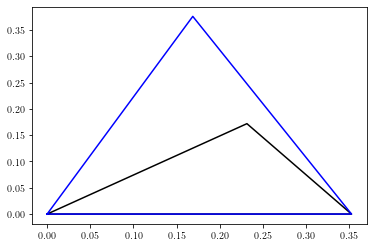

In [410]:
xm_values = [0., xm2, xm1, 0.]
ym_values = [0., ym2, ym1, 0.]
xs_values = [0., xs2, xs1, 0.]
ys_values = [0., ys2, ys1, 0.]

# with 2D projections in hand, plot some vectors on top of eachother in two different colors.
plt.plot(xs_values, ys_values, 'k')
plt.plot(xm_values, ym_values, 'b')
plt.show()

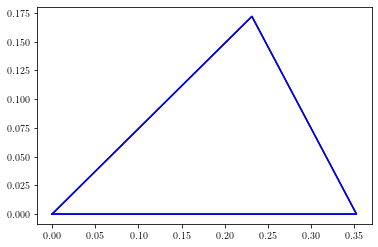

In [411]:
#TODO: test ^this by ploting a number of triangles.  do they consistently match?
xm_values = [0., xm2 + xi2*s*ym2, xm1, 0.]
ym_values = [0., xi2*ym2, ym1, 0.]
xs_values = [0., xs2, xs1, 0.]
ys_values = [0., ys2, ys1, 0.]
plt.plot(xs_values, ys_values, 'k')
plt.plot(xm_values, ym_values, 'b')
plt.show()

In [180]:
# # compute the 3D strain gradient
# def make_S_3by3(xi1, xi2, s, xhat, yhat):
#     '''returns the strain gradient in the global basis of the dynamical space.
#     s = ( xs2 - xm1 ) / ys2
#     xi2 = ys2 / ym2
#     xi1 = norm(ds1)/norm(dm1)
#     xm, ym have been rotated and scaled to be coplanar with ds1 and ds2.  '''
#     projx = np.outer(xhat,xhat)
#     projy = np.outer(yhat,yhat)
#     projy_to_x = np.outer(xhat,yhat)    
#     S = np.eye(3) + (xi2-1) * projy + xi2*s * projy_to_x 
#     S *= xi1
#     return S

# # compute the 2D strain gradient
# def make_S_2by2(xi1, xi2, s):
#     '''returns the strain gradient in the local basis of the dynamical space.
#     s = ( xs2 - xm2 ) / ys2
#     xi2 = ys2 / ym2
#     xi1 = norm(ds1)/norm(dm1)
#     xm, ym have been rotated and scaled to be coplanar with ds1 and ds2.  '''
#     return xi1 * np.array([[1., s*xi2],[0., xi2]])

In [214]:
tris = mesh.triangles[137]
trim = mesh.triangles[153]

xm2, xm1, ym2, ym1, xs2, xs1, ys2, ys1, xhat, yhat, xi1, xi2, s = align_triangles(trim,tris)

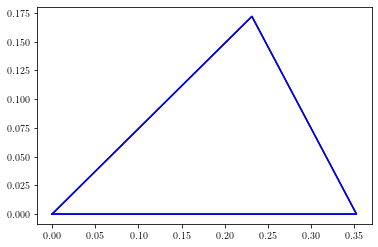

In [185]:
#TODO: test ^this by ploting a number of triangles.  do they consistently match?
xm_values = [0., xm2 + xi2*s*ym2, xm1, 0.]
ym_values = [0., xi2*ym2, ym1, 0.]
xs_values = [0., xs2, xs1, 0.]
ys_values = [0., ys2, ys1, 0.]
plt.plot(xs_values, ys_values, 'k')
plt.plot(xm_values, ym_values, 'b')
plt.show()

## DONE: testing the explicit deformation map

$$x= \phi(X)= FX + b$$
$$F = S R$$
$$b = tris[0] - trim[0]$$

In [223]:
# # collect the operations into polar decomposition of deformation gradient matrix.
# def get_SR(trim,tris, printing=True, testing=False):
#     R = get_R(trim,tris,testing=testing)
#     retval = align_triangles(trim,tris, testing=testing)
#     #TODO: make retval more compact
#     xm2, xm1, ym2, ym1, xs2, xs1, ys2, ys1, xhat, yhat, xi1, xi2, s = retval
#     S = make_S_3by3(xi1, xi2, s, xhat, yhat)
#     if (xi2<0) and printing:
#         print('xi2 is negative.')
#     if (ym2<0) and printing:
#         print('ym2 is negative.')
#     return S, R    
      
# def get_F(trim,tris, printing=True, testing=False):
#     S, R = get_SR(trim,tris, printing=printing, testing=testing)
#     F = S.dot(R)
#     return F


In [206]:
# # the explicit deformation map
# def phi(F,X,b):
#     return F.dot(X)  + b
# def get_phi(trim,tris):
#     F = get_F(trim,tris)
#     b = tris[0] - F.dot(trim[0])
#     return lambda X: phi(F,X,b)

In [224]:
# test the explicit deformation map for a number of triangles
tris = mesh.triangles[71]
trim = mesh.triangles[30]
mtos = get_phi(trim,tris)
trim_mapped = np.array([mtos(trim[0]),mtos(trim[1]),mtos(trim[2])])
print('tris is')
print(tris)
print('trim is mapped to')
print(trim_mapped)
print('difference after mapping is')
print(tris - trim_mapped)
assert(np.isclose(tris - trim_mapped,0.).all())
# print(phi(F,trim[0],b))
# print(phi(F,trim[1],b))
# print(phi(F,trim[2],b))

tris is
[[ 0.43875389 -0.77115173  0.48489936]
 [ 0.57195572 -0.75999632  0.28155448]
 [ 0.67368345 -0.62344912  0.4066898 ]]
trim is mapped to
[[ 0.43875389 -0.77115173  0.48489936]
 [ 0.57195572 -0.75999632  0.28155448]
 [ 0.67368345 -0.62344912  0.4066898 ]]
difference after mapping is
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.55111512e-17]
 [0.00000000e+00 1.11022302e-16 0.00000000e+00]]


# DONE: compute the piola-kirchoff stress tensor for the corotated linear elastic constitutive relation.  Then compute the nodal forces for a triangle stretched by a known amount.


The explicit deformation map is

$$\vec{x}= \vec{\phi}(\vec{X}; \vec{x})= \mathbf{F}(\vec{X}; \vec{x})\cdot \vec{X} + \vec{b}(\vec{X}; \vec{x})$$

where

$$\mathbf{F}(\vec{X}; \vec{x}) = \mathbf{S}\cdot\mathbf{R}$$ 
and 
$$\vec{b}(\vec{X}; \vec{x}) = tris[0] - \mathbf{F}(\vec{X}; \vec{x}) \cdot trim[0].$$

$S$ this is all that's needed to compute the elastic force for a given constitutive relation that's homogeneous and isotropic.  We suppose rotational invariance in the following elastic energy density:

$$
\Psi(F=SR) = \mu||S-\mathbb{1}||^2 + \frac{\lambda}{2}\text{tr}^2(S-\mathbb{1})
$$

Where $\mu$ and $\lambda$ are the first and second Lamé parameters, measuring resistance to stretching/shearing and volume change, respectively.

It can be shown this results in the following first Piola-Kirchoff stress tensor:

$$
\mathbf{P}(\mathbf{F})= 2\mu(\mathbf{S}-\mathbb{1})\mathbf{R} + \lambda \text{tr}(\mathbf{S}-\mathbb{1})\mathbf{R}
$$

There is the following conversion from Young's modulus, $k$, and Poisson's ratio, $\nu$:

$$
\mu = \frac{k}{2(1+\nu)},\qquad \lambda=\frac{k\nu}{(1+\nu)(1-2\nu)}
$$


In [417]:
def calc_P(S, R, mu, lam, one):
    '''corotated linear constitutive model'''
    P    = 2*mu*(S - one).dot(R) + lam*np.trace(S - 1) * R
    return P

def calc_outward_normals(trim):
    '''
    returns the outward unit normal vectors for the triangle, trim.
    trim is a 3x3 numpy array.
    '''
    #compute local unit vectors of triangle's shape and center of mass (com)
    d1, d2, A = get_shape(trim)
    c   = trim[2] - trim[1]
    c  /= np.linalg.norm(c)
    d1 /= np.linalg.norm(d1)
    d2 /= np.linalg.norm(d2)
    A  /= np.linalg.norm(A)
    com     = (trim[0]+trim[1]+trim[2])/3

    #precompute the outward normals in material space
    #and test that the outward normals are indeed outward
    N1 = np.cross(d1,A)
    N1tilde = (trim[0]+trim[1])/2 - com
    if N1.dot(N1tilde)<0:
        N1 *= -1
        print("N1 was flipped.")
    N2 = np.cross(-d2,A)
    N2tilde = (trim[0]+trim[2])/2 - com
    if N2.dot(N2tilde)<0:
        N2 *= -1
        print("N2 was flipped.")
    N3 = np.cross(c,A)
    N3tilde = (trim[2]+trim[1])/2 - com
    if N3.dot(N3tilde)<0:
        N3 *= -1
        print("N3 was flipped.")
    return N1,N2,N3

In [418]:
trim = mesh.triangles[153]

#dilate trim to make a tris with a predicted form
sscale = 2.
tris = trim*sscale

# tris = mesh.triangles[71]
# d1, d2, A = get_shape(trim)
# com     = (trim[0]+trim[1]+trim[2])/3
# (trim[0]-com)
# np.array([
#     trim[0] + d1
#     trim[0] + d2,
#     ,
# ])

In [419]:
#compute P, first Piola-Kirchoff stress tensor
mu  = 1. #first  lame parameter, kPa
lam = 1. #second lame parameter, kPa
delta = .01 #small thickness of membrane
one = np.eye(3)
S, R = get_SR(trim,tris)
P = calc_P(S, R, mu, lam, one)
N1,N2,N3 = calc_outward_normals(trim)

# print(R)

In [421]:
# # q = np.array([ 0.80631039, -0.0700592 ,  0.58732893]), array([ 0.80631039, -0.0700592 ,  0.58732893])
# w = np.array([ 0.80631039, -0.0700592 ,  0.58732893])
# w.dot(w)

In [422]:
#compute the net force on each side of tris
D1 = np.linalg.norm(tris[1]-tris[0])
D2 = np.linalg.norm(tris[2]-tris[0])
C  = np.linalg.norm(tris[2]-tris[1])
F1 = - delta * P.dot(N1) * D1
F2 = - delta * P.dot(N2) * D2
F3 = - delta * P.dot(N3) * C

In [423]:
#compute the equivalent nodal forces on each vertex of tris
nf0 = (F1 + F2)/2. 
nf1 = (F1 + F3)/2.
nf2 = (F3 + F2)/2.

In [424]:
#compute the deformed triangle
ds1, ds2, As = get_shape(tris)
dm1, dm2, Am = get_shape(trim)

#test that the local "x" axis is aligned by R
xhat = ds1 / np.linalg.norm(ds1)

#yhat is not needed for energy calculation, but is needed for deformation gradient calculation via outer product
yhat = np.cross(As, xhat)
yhat /= np.linalg.norm(yhat)

xs1 = xhat.dot(ds1)  # full length
ys1 = yhat.dot(ds1)  # zero
xs2 = xhat.dot(ds2)
ys2 = yhat.dot(ds2)

xm1 = xhat.dot(R.dot(dm1))  # full length
ym1 = yhat.dot(R.dot(dm1))  # zero
xm2 = xhat.dot(R.dot(dm2))
ym2 = yhat.dot(R.dot(dm2))

xshift = (xs2+xs1)/6
yshift = (ys2+ys1)/6
xs_values = [0., xs2, xs1, 0.]
ys_values = [0., ys2, ys1, 0.]
xm_values = np.array([0., xm2, xm1, 0.]) + xshift
ym_values = np.array([0., ym2, ym1, 0.]) + yshift

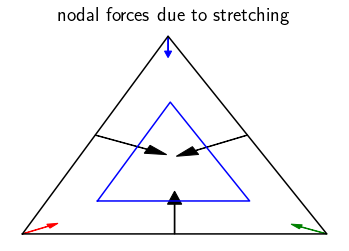

<Figure size 432x288 with 0 Axes>

In [434]:
#plot up those nodal force examples.  Are they sensible?
scale_arrows = 3.2
plt.plot(xs_values, ys_values, 'k')
plt.plot(xm_values, ym_values, 'b')


#nodal forces
plt.arrow(0,0,nf0.dot(xhat)*scale_arrows,nf0.dot(yhat)*scale_arrows, color='red', head_width=.01)
plt.arrow(xs1,ys1,nf1.dot(xhat)*scale_arrows,nf1.dot(yhat)*scale_arrows, color='green', head_width=.01)
plt.arrow(xs2,ys2,nf2.dot(xhat)*scale_arrows,nf2.dot(yhat)*scale_arrows, color='blue', head_width=.01)

#forces on the sides of triangles
plt.arrow(0+xs1/2,0+ys1/2,F1.dot(xhat)*scale_arrows,F1.dot(yhat)*scale_arrows, color='black', head_width=.02)
plt.arrow(0+xs2/2,0+ys2/2,F2.dot(xhat)*scale_arrows,F2.dot(yhat)*scale_arrows, color='black', head_width=.02)
plt.arrow(xs1/2+xs2/2,ys1/2+ys2/2,F3.dot(xhat)*scale_arrows,F3.dot(yhat)*scale_arrows, color='black', head_width=.02)


plt.title('nodal forces due to stretching', fontsize=20)
plt.axis('off')
# plt.plot(xm_values, ym_values, 'b')
plt.show()
plt.savefig(f"{nb_dir}/Figures/nodal_forces_example3.png",dpi=400)


In [435]:
# test that the nodal forces are in plane with the deformed triangle
assert(np.isclose(As.dot(nf0),0.))
assert(np.isclose(As.dot(nf1),0.))
assert(np.isclose(As.dot(nf2),0.))
assert(np.isclose(As.dot(F1),0.))
assert(np.isclose(As.dot(F2),0.))
assert(np.isclose(As.dot(F3),0.))

A Possible Future Glitch could occur if there's a lot fo twisting, which I don't expect
- if R.dot(Amhat).dot(Ashat)<0 and/or 
- if xi2 < 0

Plot force vectors, frequently and consider printing when ^these conditions occur.

# TODO: compute the net elastic force for each vertex